In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2

In [204]:
'''helper functions for data generation'''
def rgb_to_hsv(rgb):
    r, g, b = rgb[..., 0], rgb[..., 1], rgb[..., 2]
    maxc = np.maximum(r, np.maximum(g, b))
    minc = np.minimum(r, np.minimum(g, b))
    v = maxc
    deltac = maxc - minc
    s = deltac / maxc
    s = np.where(maxc == 0, 0, s)
    deltac_recip = 1 / deltac
    rc = (maxc - r) * deltac_recip
    gc = (maxc - g) * deltac_recip
    bc = (maxc - b) * deltac_recip
    h = np.where(maxc == r, bc - gc,
                 np.where(maxc == g, 2.0 + rc - bc, 4.0 + gc - rc))
    h = (h / 6.0) % 1.0
    return np.stack([h, s, v], axis=-1)

def hsv_to_rgb(hsv):
    h, s, v = hsv[..., 0], hsv[..., 1], hsv[..., 2]
    i = (h * 6).astype(np.int32)
    f = h * 6 - i
    p = v * (1 - s)
    q = v * (1 - s * f)
    t = v * (1 - s * (1 - f))
    i = i % 6

    conditions = [s == 0, i == 0, i == 1, i == 2, i == 3, i == 4, i == 5]
    rgb_lists = [
        (v, v, v),
        (v, t, p),
        (q, v, p),
        (p, v, t),
        (p, q, v),
        (t, p, v),
        (v, p, q)
    ]

    r, g, b = np.select(conditions, rgb_lists)
    return np.stack([r, g, b], axis=-1)

def generate_data(n):
    rgb_colors = np.random.rand(n, 3)
    hsv_colors = rgb_to_hsv(rgb_colors)
    return rgb_colors, hsv_colors

def plot_colors(rgb_list, hsv_list):
    # Ensure that the inputs are 2D arrays (i.e., lists of colors)
    if len(np.shape(rgb_list)) == 1:
        rgb_list = np.expand_dims(rgb_list, axis=0)
    if len(np.shape(hsv_list)) == 1:
        hsv_list = np.expand_dims(hsv_list, axis=0)
    
    # Create empty list to store patches
    patches = []

    # For each RGB and HSV pair
    for rgb, hsv in zip(rgb_list, hsv_list):
        # Convert HSV to RGB
        rgb_from_hsv = hsv_to_rgb(hsv)
        
        # Scale to 255 for visualization
        rgb_patch = (rgb * 255).astype(np.uint8)
        hsv_patch = (rgb_from_hsv * 255).astype(np.uint8)

        # Create a vertical patch for each color
        combined_patch = np.vstack((np.ones((50, 100, 3), dtype=np.uint8) * rgb_patch,
                                    np.ones((50, 100, 3), dtype=np.uint8) * hsv_patch))
        patches.append(combined_patch)

    # Combine all patches horizontally
    combined_image = np.hstack(patches)

    # Display using matplotlib
    plt.figure(figsize=(15, 5))
    plt.imshow(combined_image)
    plt.title("Colors: RGB (Top) vs. HSV (Bottom)")
    plt.axis('off')
    plt.show()

X, Y = generate_data(20000)

In [66]:
def generate_class_data(n):
    dataset = []
    labels = []
    X = np.random.uniform(0,1,(n,2))
    for point in X:
        if point[1] < 0.5 and point[1] < (-1/0.5)*point[0] + 1:
            labels.append(0)
        else:
            labels.append(1)
            
    return X, np.array(labels).astype('int')
X, labels = generate_class_data(5000)

In [205]:
class FFNN:
    def __init__(self, layer_sizes, 
                 activation_fn, activation_fn_deriv, 
                 output_activation_fn, output_activation_fn_deriv, 
                 loss_fn, loss_fn_deriv, task_type='classification'):
        self.num_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.activation_fn = activation_fn
        self.activation_fn_deriv = activation_fn_deriv
        self.output_activation_fn = output_activation_fn
        self.output_activation_fn_deriv = output_activation_fn_deriv
        self.loss_fn = loss_fn
        self.loss_fn_deriv = loss_fn_deriv
        self.task_type = task_type
        
        # Initialize weights and biases
        self.W = [np.random.randn(layer_sizes[i+1], layer_sizes[i]) * np.sqrt(2./layer_sizes[i]) 
                  for i in range(self.num_layers-1)]
        self.b = [np.random.randn(layer_sizes[i+1], 1) for i in range(self.num_layers-1)]

    def forward(self, x):
        a = [x]
        z = []
        
        # Hidden layers
        for i in range(self.num_layers-2):
            z_i = self.W[i].dot(a[i]) + self.b[i]
            a_i = self.activation_fn(z_i)
            z.append(z_i)
            a.append(a_i)
        
        # Output layer
        z_out = self.W[-1].dot(a[-1]) + self.b[-1]
        a_out = self.output_activation_fn(z_out)
        z.append(z_out)
        a.append(a_out)
        
        return a_out, a, z
    
    def compute_loss(self, predictions, t):
        # Ensure the target shape matches the predictions
        if t.shape[0] != predictions.shape[0]:
            t = t.T
        return self.loss_fn(predictions, t)
    
    def _one_hot(self, inputs):
        n_values = len(np.unique(inputs))
        return np.eye(n_values)[:,inputs]
    
    def backward(self, x, t, a, z):
        m = x.shape[1]
        dL_dw = [np.zeros_like(w) for w in self.W]
        dL_db = [np.zeros_like(b) for b in self.b]
        
        # Ensure the target shape matches the predictions
        if t.shape[0] != a[-1].shape[0]:
            t = t.T
        
        dL_da = self.loss_fn_deriv(a[-1], t)
        dL_dz = dL_da * self.output_activation_fn_deriv(z[-1])
        
        dL_dw[-1] = dL_dz.dot(a[-2].T)
        dL_db[-1] = np.sum(dL_dz, axis=1, keepdims=True)
        
        for i in range(self.num_layers-3, -1, -1):
            dL_da = self.W[i+1].T.dot(dL_dz)
            dL_dz = dL_da * self.activation_fn_deriv(z[i])
            dL_dw[i] = dL_dz.dot(a[i].T)
            dL_db[i] = np.sum(dL_dz, axis=1, keepdims=True)
        
        return dL_dw, dL_db
    
    def update_weights(self, dL_dw, dL_db, learning_rate):
        self.W = [w - learning_rate * dw for w, dw in zip(self.W, dL_dw)]
        self.b = [b - learning_rate * db for b, db in zip(self.b, dL_db)]
        
    def train(self, X, labels, learning_rate=0.01, epochs=1000, batch_size=None):
        """Trains the neural network using the given training data and labels."""
        m = X.shape[1]

        for epoch in range(epochs):
            if batch_size:  # If batch size is specified, use mini-batch gradient descent
                num_batches = m // batch_size
                for batch in range(num_batches):
                    X_batch = X[:, batch*batch_size:(batch+1)*batch_size]
                    labels_batch = labels[batch*batch_size:(batch+1)*batch_size]

                    # Forward pass
                    predictions, a_batch, z_batch = self.forward(X_batch)
                    
                    # Backward pass
                    dL_dw, dL_db = self.backward(X_batch, labels_batch, a_batch, z_batch)

                    # Update weights and biases
                    self.update_weights(dL_dw, dL_db, learning_rate)
            else:  # Otherwise, use batch gradient descent
                # Forward pass
                predictions, a_full, z_full = self.forward(X)
                
                # Backward pass
                dL_dw, dL_db = self.backward(X, labels, a_full, z_full)

                # Update weights and biases
                self.update_weights(dL_dw, dL_db, learning_rate)

            # Print loss at the end of each 100 epochs:
            if epoch % 100 == 0:
                # Ensure activations are for the entire dataset
                predictions, _, _ = self.forward(X)
                loss = self.compute_loss(predictions, labels)
                print(f"Epoch {epoch+1}/{epochs} - Loss: {np.mean(loss)}")

In [206]:
def ReLU(inputs):
    return np.maximum(inputs, 0)
def deriv_ReLU(Z):
    return Z>0

def sigmoid(inputs, clip_value=200):
    inputs = np.clip(inputs, -clip_value, clip_value)
    return 1 / (1 + np.exp(-inputs))

def deriv_sigmoid(inputs):
    return(inputs*(1-inputs))

def Linear(inputs):
    return (1/10)*inputs

def deriv_Linear(inputs):
    return inputs*0 + (1/10)

def clipped_ReLU(x, c=1):
    return np.minimum(np.maximum(0, x), c)

def deriv_clipped_ReLU(inputs):
    return (inputs>0) & (inputs<1)

def L2(outputs, targets):
    return 0.5*sum((outputs - targets)**2)

def deriv_L2(outputs, targets):
    return outputs - targets

def one_hot(inputs):
    n_values = np.max(inputs) + 1
    return np.eye(n_values)[:,inputs]

def softmax(Z):
    shiftZ = Z - np.max(Z, axis=0)
    exps = np.exp(shiftZ)
    return exps / np.sum(exps, axis=0)

def dummy_deriv_softmax(Z):
    return Z

def categorical_cross_entropy(predictions, labels):
    m = labels.shape[1]
    return -np.sum(np.log(predictions) * labels) / m

def deriv_cat_cross_entropy(predictions, labels):
    return predictions - labels  




In [207]:
layer_sizes = [3,30,3]

ffnn = FFNN(layer_sizes = layer_sizes, 
                activation_fn = ReLU, 
                activation_fn_deriv = deriv_ReLU, 
                output_activation_fn = Linear, 
                output_activation_fn_deriv = deriv_Linear, 
                loss_fn = L2, 
                loss_fn_deriv = deriv_L2,
                task_type='regression')

ffnn.train(X.T, Y, learning_rate=0.001, epochs = 3000, batch_size=2000)

Epoch 1/3000 - Loss: 0.08516999923072092
Epoch 101/3000 - Loss: 0.021990920592541124
Epoch 201/3000 - Loss: 0.01871483160516246
Epoch 301/3000 - Loss: 0.016106605696559476
Epoch 401/3000 - Loss: 0.013604489252377698
Epoch 501/3000 - Loss: 0.011519789654065346
Epoch 601/3000 - Loss: 0.010041862732917517
Epoch 701/3000 - Loss: 0.009014748215954762
Epoch 801/3000 - Loss: 0.008223171526960046
Epoch 901/3000 - Loss: 0.00759061258473389
Epoch 1001/3000 - Loss: 0.007162305024142605
Epoch 1101/3000 - Loss: 0.007575754851592386
Epoch 1201/3000 - Loss: 0.007357665456477429
Epoch 1301/3000 - Loss: 0.007112143114320328
Epoch 1401/3000 - Loss: 0.006821647316424006
Epoch 1501/3000 - Loss: 0.006504974607482655
Epoch 1601/3000 - Loss: 0.006298831113043022
Epoch 1701/3000 - Loss: 0.006186581411074203
Epoch 1801/3000 - Loss: 0.0060543460490128705
Epoch 1901/3000 - Loss: 0.005899707870444157
Epoch 2001/3000 - Loss: 0.005753530712159239
Epoch 2101/3000 - Loss: 0.005697443588357876
Epoch 2201/3000 - Loss: 

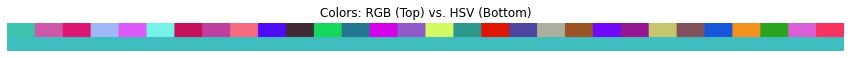

In [216]:
rgb = X[100:130]

hsv,_,_ = ffnn.forward(rgb.T)
plot_colors(rgb, hsv.T)

In [215]:
ffnn.train(X.T, Y, learning_rate=0.004, epochs = 3000, batch_size=2000)

Epoch 1/3000 - Loss: 0.08842824445194719
Epoch 101/3000 - Loss: 0.08842798491145788
Epoch 201/3000 - Loss: 0.08842798491145788
Epoch 301/3000 - Loss: 0.08842798491145788
Epoch 401/3000 - Loss: 0.08842798491145788
Epoch 501/3000 - Loss: 0.08842798491145788
Epoch 601/3000 - Loss: 0.08842798491145788
Epoch 701/3000 - Loss: 0.08842798491145788
Epoch 801/3000 - Loss: 0.08842798491145788
Epoch 901/3000 - Loss: 0.08842798491145788
Epoch 1001/3000 - Loss: 0.08842798491145788
Epoch 1101/3000 - Loss: 0.08842798491145788


KeyboardInterrupt: 